# Vehicle detection¶
Self Driving Car Nanodegree 
By Nicholas Johnson 

<h2> Vehicle Detection and Tracking Project</h2> 
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
 


## 1. Feature extraction
Extract features from an images to decide if a car is present. I mainly focused on the HOG (Histogram of Oriented Gradient) and the color features for detetction. There are other things we could look at too, like reflectivity, and object traits. 

In [1]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#Note the last import is only valid for scikit-learn version >= 0.18
#for scikit-learn <= 0.18 use:
#from sklearn.cross_validation import train_test_split
print('...done')

...done


In [2]:
import os 
import glob 
#images are divided up into vehicles and non-vehicles folders 
#Each of which contains imgs and CSV classifers 
#first locate vheciles img 
basedir = '../vehicles/'
#Different folders represent different sources of images, e.g. GTi, Kitti, etc.. 
image_types = os.listdir(basedir)
cars =[]
for imtype in image_types: 
    cars.extend(glob.glob(basedir+imtype+'/*'))

print('number of vehcile images found: ', len(cars))
with open("cars.text", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        
#Do the same thing for non vehicle images 
basedir = '../non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types: 
    notcars.extend(glob.glob(basedir+imtype+'/*'))
print('number of non-vehicle images found: ', len(notcars))
with open("notcars.text", 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

number of vehcile images found:  8792
number of non-vehicle images found:  8968


In [3]:
#Define a function to return HOG features and visualization 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  block_norm='L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm='L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# define a function to compute binned color features 
# def bin_spatial(img, size=(32,32)):
# Use cv2,resize().ravel() to create the features vector 
# feature = cv2.resize(img,size).ravel()
# return the feature vector 
# return features 

# Down sample the images - 64x64 to 32x32 
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# Need to Chnage if reading .png files with mping! 
# Changed to get ride of bin range all together and let it be automatic 
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pixel_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pixel_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pixel_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            #print('Converting to YCrCb')
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)) 
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image 
    else:
        return np.concatenate(img_features)

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                         spatial_feat=True, hist_feat=True, hog_feat=True):    
#     #1) Define an empty list to receive features
#     img_features = []
#     #2) Apply color conversion if other than 'RGB'
#     if color_space != 'RGB':
#         if color_space == 'HSV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#         elif color_space == 'LUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#         elif color_space == 'HLS':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#         elif color_space == 'YUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#         elif color_space == 'YCrCb':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     else: feature_image = np.copy(img)      
#     #3) Compute spatial features if flag is set
#     if spatial_feat == True:
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         #4) Append features to list
#         img_features.append(spatial_features)
#     #5) Compute histogram features if flag is set
#     if hist_feat == True:
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         #6) Append features to list
#         img_features.append(hist_features)
#     #7) Compute HOG features if flag is set
#     if hog_feat == True:
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.extend(get_hog_features(feature_image[:,:,channel], 
#                                     orient, pix_per_cell, cell_per_block, 
#                                     vis=False, feature_vec=True))      
#         else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         #8) Append features to list
#         img_features.append(hog_features)

#     #9) Return concatenated array of features
#     return np.concatenate(img_features)


# # Define a function you will pass an image 
# # and the list of windows to be searched (output of slide_windows())
# def search_windows(img, windows, clf, scaler, color_space='RGB', 
#                     spatial_size=(32, 32), hist_bins=32, 
#                     hist_range=(0, 256), orient=9, 
#                     pix_per_cell=8, cell_per_block=2, 
#                     hog_channel=0, spatial_feat=True, 
#                     hist_feat=True, hog_feat=True):

#     #1) Create an empty list to receive positive detection windows
#     on_windows = []
#     #2) Iterate over all windows in the list
#     for window in windows:
#         #3) Extract the test window from original image
#         test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
#         #4) Extract features for that window using single_img_features()
#         features = single_img_features(test_img, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat, vis=vis)
#         #5) Scale extracted features to be fed to classifier
#         test_features = scaler.transform(np.array(features).reshape(1, -1))
#         #6) Predict using your classifier
#         prediction = clf.predict(test_features)
#         #7) If positive (prediction == 1) then save the window
#         if prediction == 1:
#             on_windows.append(window)
#     #8) Return windows for positive detections
#     return on_windows

#     #1) Create an empty list to receive positive detection windows
#     on_windows = []
#     #2) Iterate over all windows in the list
#     for window in windows:
#         #3) Extract the test window from original image
#         test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
#         #4) Extract features for that window using single_img_features()
#         features = single_img_features(test_img, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)
#         #5) Scale extracted features to be fed to classifier
#         test_features = scaler.transform(np.array(features).reshape(1, -1))
#         #6) Predict using your classifier
#         prediction = clf.predict(test_features)
#         #7) If positive (prediction == 1) then save the window
#         if prediction == 1:
#             on_windows.append(window)
#     #8) Return windows for positive detections
#     return on_windows

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows



print('done')

done


In [13]:
# Define a function for plotting multiple images 
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims <= 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[1])
        else:
            plt.imshow(img)
            plt.title(titles[1])

from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    #zero out pixel bellow some threshold value
    heatmap[heatmap ,+ threshold] = 0
    #return threshold map
    return heatmap 

def draw_labeled_boxes(img, lables):
    #interate through all detected cars 
    for car_number in range(1, labels[1]+1):
        #find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        #indentify x and y values of those pixels 
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        #define a bounding box based on min and mox z & y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)),(np.max(nonzerox), np.max(nonzeroy)))
        #draw teh bix on teh image 
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,255), 4 )
    #Retrun img 
    return img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV' :
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

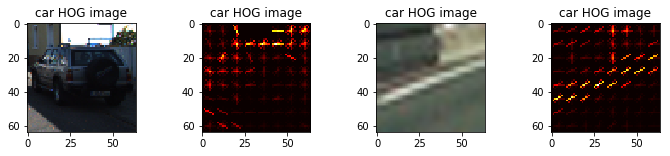

In [14]:
%matplotlib inline

# choose random car / not car indices 
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# read in cars & notcars images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# define features parameters 
color_space = 'RGB' #can be RGB, HSV, LUV, HLS, YUV. YCrCb 
orient = 6 
pixel_per_cell = 8
cell_per_block = 2 
hog_channel = 1 # Can be 0,1, 2, or "ALL"
spatial_size = (32, 32) #spatial binning dimensions 
hist_bins = 32 # number of histogram bins 
spatial_feat = True # spatial features on or off
hist_feat = True # histogram features on or off 
hog_feat = True # HOG features on or off 


car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                                                  hist_bins=hist_bins, orient=orient,
                                                  pix_per_cell=pixel_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat, hist_feat = hist_feat, hog_feat=hog_feat, vis=True)  

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                                                  hist_bins=hist_bins, orient=orient,
                                                  pix_per_cell=pixel_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat, hist_feat = hist_feat, hog_feat=hog_feat,vis=True) 

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,2)) #, dpi=80) 
visualize(fig, 1, 4, images, titles)


# Train a model on the classified images 

In [6]:
# Define features parameters 
color_space = 'YCrCb' #can be RGB, HSV, LUV, HLS, YUV. YCrCb 
orient = 9 # Based on HOG paper 
pixel_per_cell = 8 
cell_per_block = 2 
hot_channel = 'ALL' # Can be 0, 1, 2, or 'ALL'
spatial_size = (32, 32) #spatial binning dimensions 
hist_bins = 32 # number of histogram bins 
spatial_feat = True # spatial features on or off
hist_feat = True # histogram features on or off 
hog_feat = True # HOG features on or off 
print('Define the input perameters for the model')

Define the input perameters for the model


In [16]:
#training the network. 
t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs]
test_notcars = notcars #np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, 
                                spatial_size=spatial_size,hist_bins=hist_bins, 
                                orient=orient, pixel_per_cell=pixel_per_cell, 
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

print ('car_features samples: ', len(car_features))

notcar_features = extract_features(test_notcars, color_space=color_space, 
                                spatial_size=spatial_size,hist_bins=hist_bins, 
                                orient=orient, pixel_per_cell=pixel_per_cell, 
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)


print ('Notcar samples: ', len(notcar_features))

print(time.time()-t, 'Seconds to compute features')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X) 
print ('X_scaler: ', X_scaler) 
# We fit the scaller sklearn model selection - 
# Fit a per-column scaler
scaled_X = X_scaler.transform(X)  
print ('scaled_X: ', scaled_X.shape)

# Define the labels vector 
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print ('ylabel vetector shape: ', y.shape)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations |', pixel_per_cell,
      'pixels per cell| ', cell_per_block,'cells per block |', 
      hist_bins, "histogram bins and |", spatial_size, 'Spatial size')

print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(loss='hinge') # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) 

car_features samples:  8792
Notcar samples:  8968
37.98688840866089 Seconds to compute features
X_scaler:  StandardScaler(copy=True, with_mean=True, with_std=True)
scaled_X:  (17760, 4344)
ylabel vetector shape:  (17760,)
Using: 6 orientations | 8 pixels per cell|  2 cells per block | 32 histogram bins and | (32, 32) Spatial size
Feature vector length: 4344
12.39 Seconds to train SVC...
Test Accuracy of SVC =  0.9752


# Test models capabilities 

0.0 1.0
0.524416446685791 seconds to porcess one image searching 273 windows
0.0 1.0
0.5042219161987305 seconds to porcess one image searching 273 windows
0.0 1.0
0.5074827671051025 seconds to porcess one image searching 273 windows
0.0 1.0
0.5086569786071777 seconds to porcess one image searching 273 windows
0.0 1.0
0.5539424419403076 seconds to porcess one image searching 273 windows
0.0 1.0
0.5131361484527588 seconds to porcess one image searching 273 windows


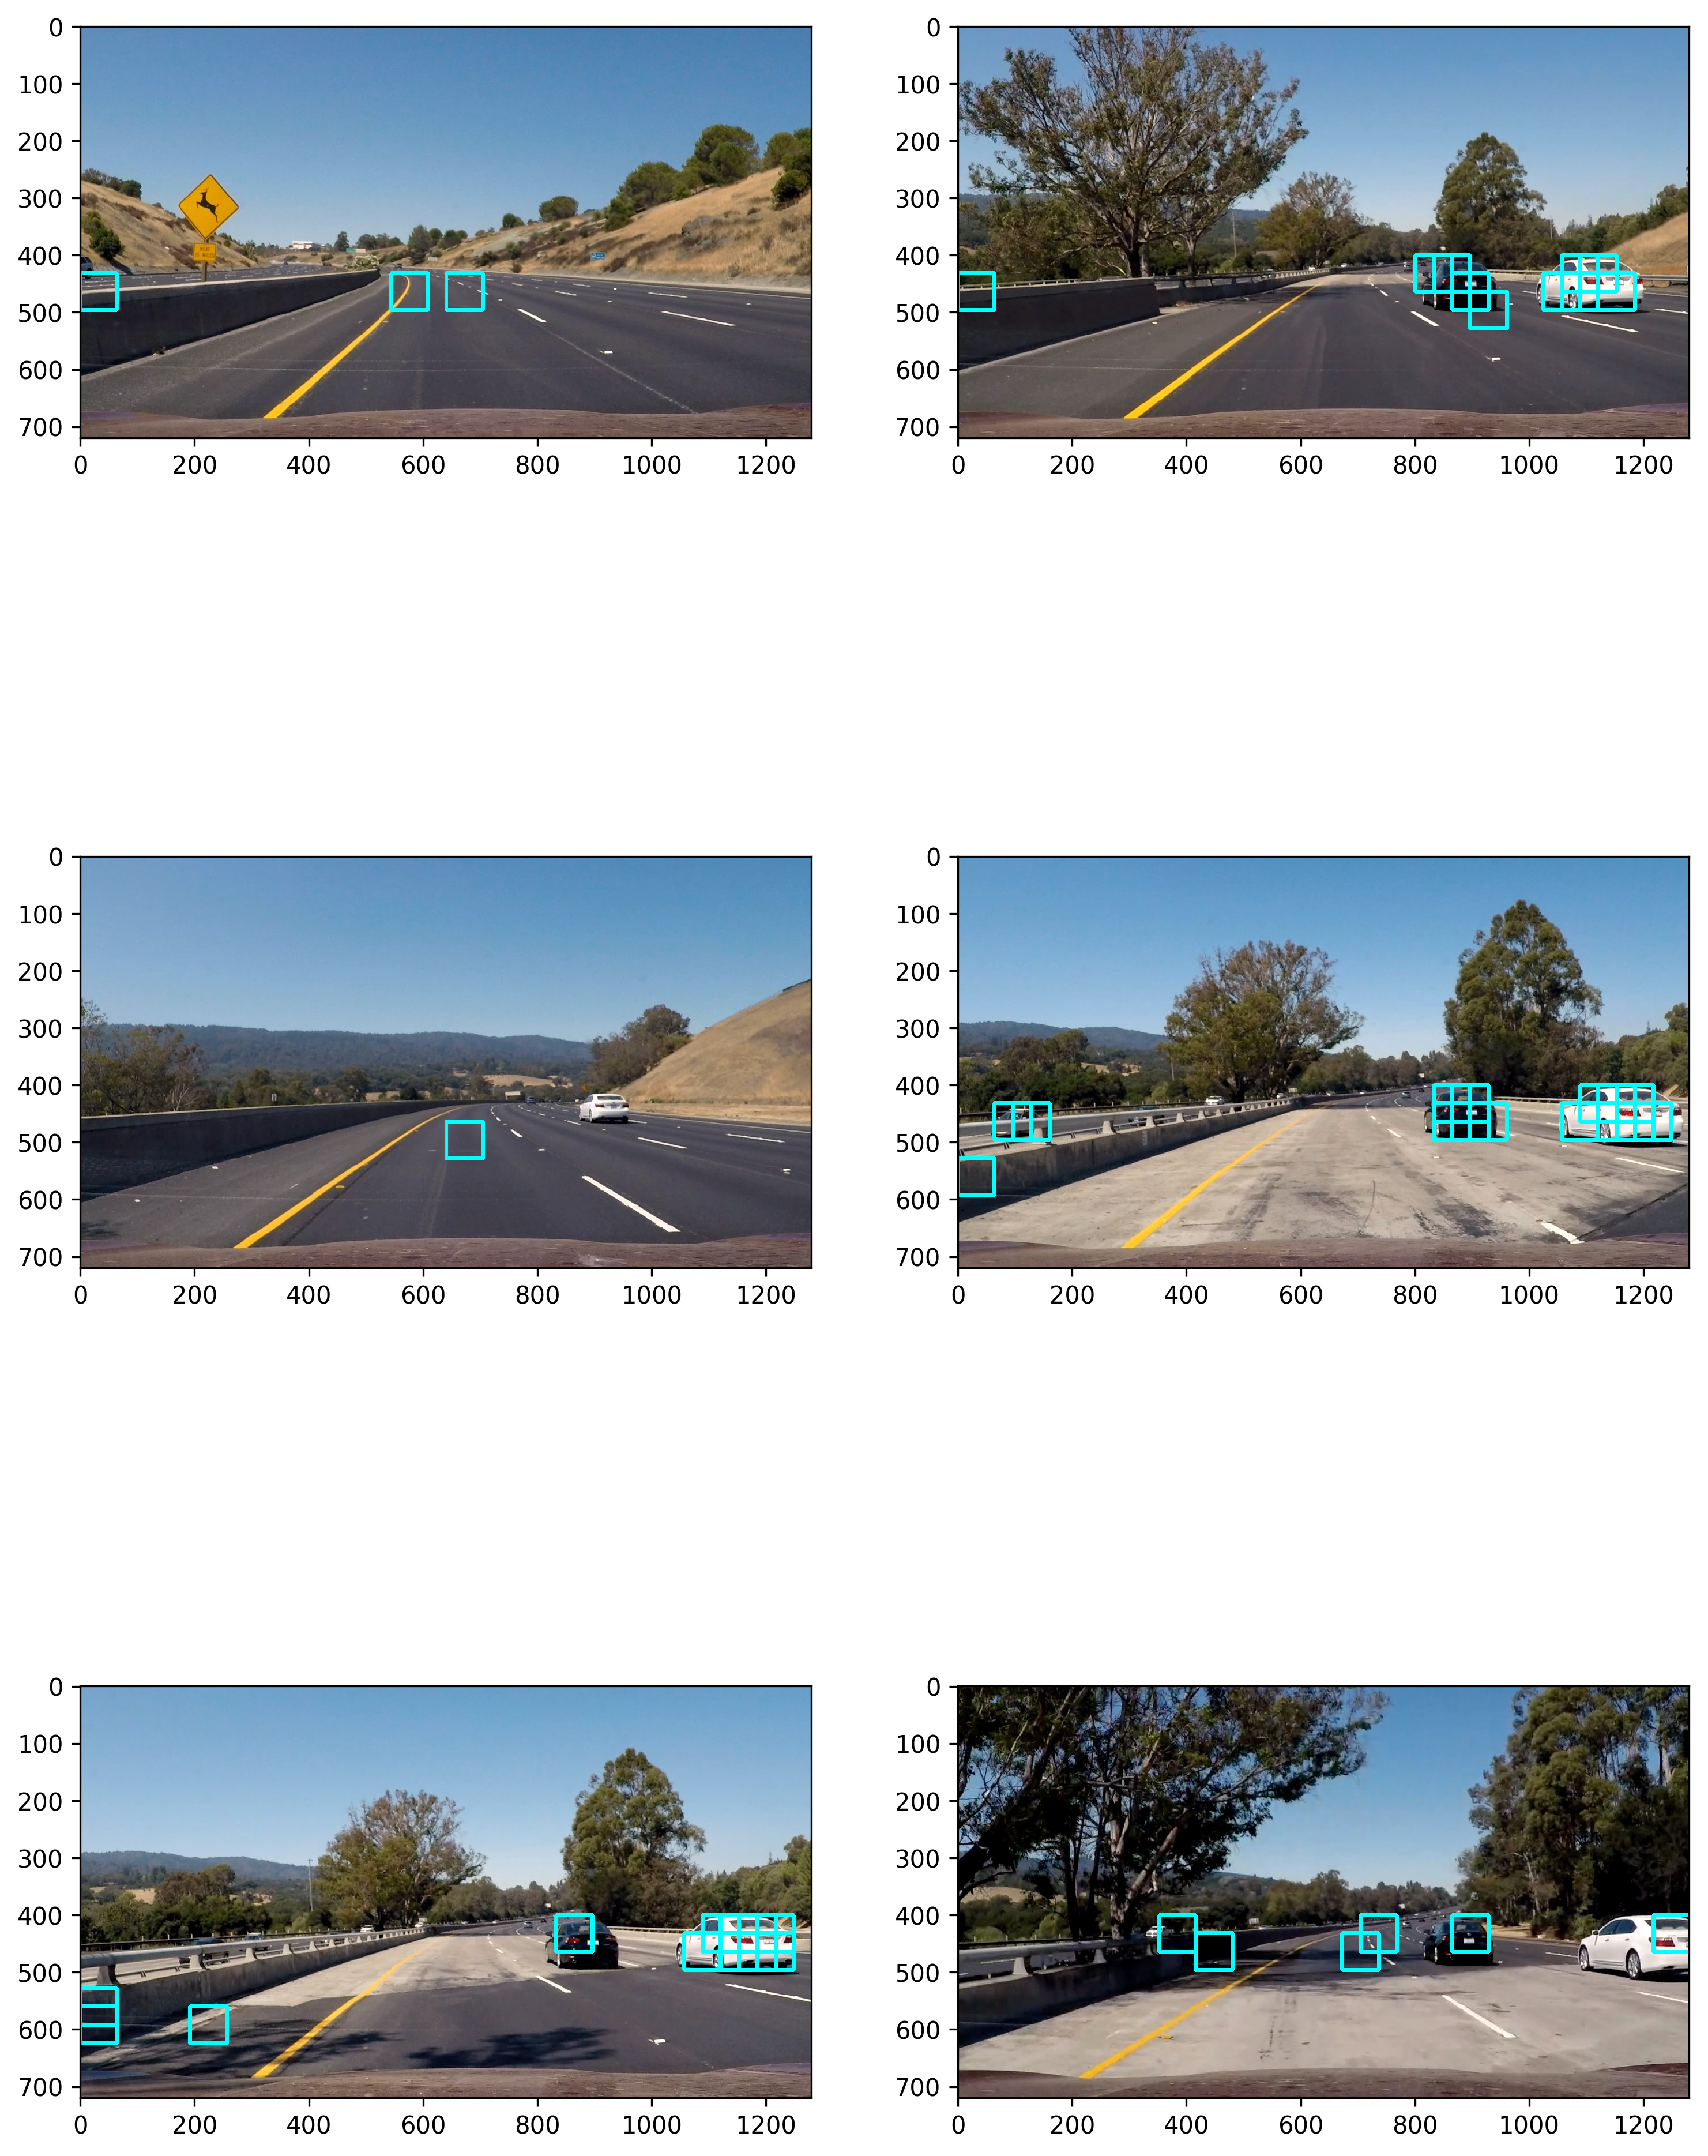

In [17]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
#hog_channel = 1 # Can be 0,1, 2, or "ALL"
images = []
titles =[]
y_start_stop = [400, 656] # min and max in y to search in slide_window() 
overlap = 0.5 
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255 # Important becuase we are training on png and now running on jpg 
    print(np.min(img), np.max(img))
    
#     windows1 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
#                            xy_window=(64, 64), xy_overlap=(overlap, overlap))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                           xy_window=(64, 64), xy_overlap=(overlap, overlap))
    
#     windows = windows1 + windows2
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 hist_range=(0,255), orient=orient,pix_per_cell=pixel_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0,255,255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to porcess one image searching', len(windows), 'windows')
fig = plt.figure(figsize=(12,18), dpi=300)

visualize(fig, 3, 2, images, titles)

In [18]:
# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

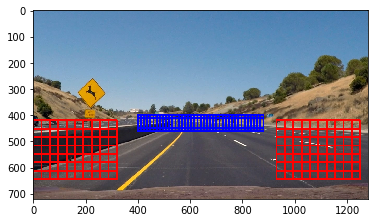

In [19]:
image = cv2.imread('./test_images/test2.jpg')
windows = slide_window(image, x_start_stop=[930, None], y_start_stop=[420, 650], 
                       xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[0, 350], y_start_stop=[420, 650], 
                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 
windows = slide_window(image, x_start_stop=[400, 880], y_start_stop=[400, 470], 
                       xy_window=(48, 48), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)
show_img(window_img)

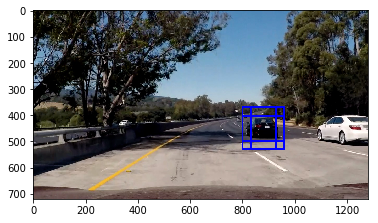

In [20]:
image = cv2.imread('test_images/test5.jpg')
track = (880, 450)
w_size = 80
windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size], 
                       y_start_stop=[track[1]-w_size,track[1]+w_size], 
                       xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
# windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size], 
#                        y_start_stop=[track[1]-int(w_size),track[1]+int(w_size)], 
#                        xy_window=(48, 48), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)                    
show_img(window_img)

# Test finding car algorithum before declaring it a funtions 

In [25]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
# Consider a narrower swatch in y
ystart = 400
ystop = 656
scale = 1.5 # anouther trick to search different window sizes / scale the entire img  


for img_src in example_images:
   
    img_boxes=[]
    t=time.time()
    count = 0
    img = mpimg.imread(img_src)
    #Run fuction to find cars 
    
    
    draw_img = np.copy(img)
    # make a heatmap of zeros 
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')

    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
     # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pixel_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pixel_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pixel_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pixel_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pixel_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pixel_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            count += 1
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            print('Hog_features shape: ', hog_features.shape)
            
            xleft = xpos*pixel_per_cell
            ytop = ypos*pixel_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            print('subimg shape: ', subimg.shape)  
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            print('spatial_features shape: ', spatial_features.shape)
            hist_features = color_hist(subimg, nbins=hist_bins)
            print('hist_features shape: ', hist_features.shape)
            
            features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1) #This should Reshap thinsg correcly 
            print('features shape: ', features.shape)
            #Scale features and make a prediction
            #test_features = np.hstack((spatial_features, hist_features, hog_features)).astype(np.float64)
            test_features = X_scaler.transform(features)
            print('test_features shape: ', test_features.shape)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            print('test_prediction shape: ', test_prediction.shape)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    
    print(time.time()-t,'seconds to run, total windows', count)
    out_images.append(draw_img) 
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    #heatmap = 255*heatmap/np.max(heatmap)
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
        
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)


Hog_features shape:  (3528,)
subimg shape:  (64, 64, 3)
spatial_features shape:  (3072,)
hist_features shape:  (96,)
features shape:  (1, 6696)


ValueError: operands could not be broadcast together with shapes (1,6696) (4344,) (1,6696) 

In [ ]:
def find_cars_oigin(img, ystart, ystop, scale, svc, X_scaler, orient, pixel_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pixel_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pixel_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pixel_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pixel_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pixel_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pixel_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            print('hog_features ',hog_features)
            
            xleft = xpos*pixel_per_cell
            ytop = ypos*pixel_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (96,96))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            print('spatial_features ',spatial_features)
            hist_features = color_hist(subimg, nbins=hist_bins)
            print('hist_features ', hist_features)
           
            # Scale features and make a prediction
            #test_features =  X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            test_features =  X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            print('test_features', test_features.shape)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            print(test_prediction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.8
    
out_img = find_cars_oigin(img, ystart, ystop, scale, svc, X_scaler, orient, pixel_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)